# 8-puzzle problem with BFS and A* Search Algorithms in Python

The 8-puzzle is a classic sliding puzzle game where the objective is to rearrange a set of 8 numbered tiles in a 3x3 grid to match a given goal configuration. In this Python code, we are solving the 8-puzzle problem using two (2) popular search algorithms: Breadth-First Search (BFS) and A* Search.

At the end we benchmark each algorithms with increasing problem complexity and compare their performance.

## Variable and Class Definition

### Initialization

First, import required Python libraries.

In [1]:
import random
import copy
import time
import matplotlib.pyplot as plt

The **puzzle size is 3x3 by default** since the goal is to solve an 8-puzzle problem. However, the code below supports user-defined column and row size.

Please take note that the bigger the puzzle the *slower the solution* and may result *unexpected behavior* for huge puzzle size.

In [2]:
cols, rows = (3, 3)

### Puzzle Class

The **Puzzle** class defines a sliding tile problem.

- Instance of the class will start as solved.
- Print function can be used to display the puzzle. Although shown as a 2D puzzle when displayed, the puzzle is stored as single-dimension array for simplicity.
- The class also support the functions to move tiles, check valid moves, shuffle the puzzle, and check if puzzle is solved.

In [3]:
class Puzzle():
    # constructor
    def __init__(self, cols, rows):
        # save dimension and init blank spot
        self.cols = cols
        self.rows = rows
        
        # build number list
        self.board = []
        for i in range(cols*rows):
            self.board.append(i)
        self.goal = self.board.copy()
            
        # set blank
        self.blank = 0
    
    # called when print() is used with the class object, to display the 2D puzzle
    def __str__(self):
        # calculate cell length
        str_len = len(str(self.rows * self.cols -1)) + 2
        build_str = ''
        
        col, row = (0, self.rows-1)
        build_str = build_str + ('|' + '-' * str_len) * self.cols + '|\n' # top border
        for i in range(self.cols*self.rows):
            if self.board[i] == 0: # if 0 then put as blank
                build_str = build_str + '|' + ' ' * str_len
            else:
                build_str = build_str + '|' + ('%d' % self.board[i]).center(str_len)
            col = col + 1
            if col == self.cols:
                col = 0
                row = row - 1
                build_str = build_str + '|\n' + ('|' + '-' * str_len) * self.cols + '|\n' # bottom border
                
        return build_str
    
    # used the __str__ function to return the object's string representation
    def __repr__(self):
        return self.__str__()
    
    # swap given tile with the blank tile
    def swap(self, tile):
        val = self.board[tile]
        self.board[self.blank] = val
        self.board[tile] = 0
        self.blank = tile
    
    # check if given move is valid
    def can_move(self, move):
        valid_moves = ['up', 'down', 'right', 'left']
        valid = False
        if move in valid_moves:
            if move == 'up':
                valid = self.blank < ((self.cols * self.rows) - self.cols)
            if move == 'down':
                valid = self.blank > (self.cols - 1)
            if move == 'right':
                valid = self.blank % self.cols > 0
            if move == 'left':
                valid = (self.blank + 1) % self.cols > 0
        return valid
    
    # move puzzle in reference to the blank tile
    def move(self, move):
        move_flag = False
        if move in ['up', 'down', 'right', 'left']:
            if move == 'up' and self.can_move('up'):
                self.swap(self.blank + self.cols)
                move_flag = True
            if move == 'down' and self.can_move('down'):
                self.swap(self.blank - self.cols)
                move_flag = True
            if move == 'right' and self.can_move('right'):
                self.swap(self.blank - 1)
                move_flag = True
            if move == 'left' and self.can_move('left'):
                self.swap(self.blank + 1)
                move_flag = True
        return move_flag
    
    # shuffle entire puzzle by randomly moving tiles
    def shuffle(self, moves):
        previous_move = None
        while moves > 0:
            move = random.choice(['up', 'down', 'right', 'left'])
            if move == 'up' and previous_move != 'down':
                if self.move('up'):
                    previous_move = 'up'
                    moves = moves - 1
            if move == 'down' and previous_move != 'up':
                if self.move('down'):
                    previous_move = 'down'
                    moves = moves - 1
            if move == 'right' and previous_move != 'left':
                if self.move('right'):
                    previous_move = 'right'
                    moves = moves - 1
            if move == 'left' and previous_move != 'right':
                if self.move('left'):
                    previous_move = 'left'
                    moves = moves - 1
    
    # check if puzzle is solved
    def is_solved(self):
        return self.board == self.goal # compare to the goal

#### Test Puzzle Class

To test the Puzzle class, let's instantiate a puzzle from the given number of column and row (3x3). Then print it to show the start state (which is also the goal state).

In [4]:
puzzle = Puzzle(cols, rows)
print(puzzle)

|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|



When we check the newly-instantiated puzzle if it is solved. It should show as **True**.

In [5]:
puzzle.is_solved()

True

Perform a shuffle by providing the number of moves of the shuffle. The higher the number of moves, the more complex the solution.

In [6]:
puzzle.shuffle(100)

Then display the shuffled puzzle.

In [7]:
puzzle

|---|---|---|
| 8 | 3 | 6 |
|---|---|---|
| 5 | 2 | 1 |
|---|---|---|
| 7 | 4 |   |
|---|---|---|

Let's check if this shuffled puzzle is solved. It should show as **False**.

In [8]:
puzzle.is_solved()

False

### Node Class

The **Node** class defined a node in a tree data structure. The class also provide references to a parent and four (4) child nodes. These child nodes represents each moves: up, down, right, and left.

In [9]:
class Node():
    # constructor
    def __init__(self, state):
        self.depth = 0
        self.state = state
        self.child = [None, None, None, None]
        self.parent = None
        self.move = None
    
    # string representation of the class
    def __str__(self):
        return self.state
    
    # duplicate node class used by expand function
    def duplicate(self):
        dupe = copy.deepcopy(self)
        dupe.depth = dupe.depth + 1
        dupe.child = [None, None, None, None]
        dupe.parent = None
        dupe.move = None
        return dupe
    
    # expand child node
    def expand(self, states):
        if self.state.can_move('up'):
            self.child[0] = self.duplicate()
            self.child[0].state.move('up')
            if self.child[0].state.board in states:
                self.child[0] = None
            else:
                self.child[0].parent = self
                self.child[0].move = "up"
        if self.state.can_move('down'):
            self.child[1] = self.duplicate()
            self.child[1].state.move('down')
            if self.child[1].state.board in states:
                self.child[1] = None
            else:
                self.child[1].parent = self
                self.child[1].move = "down"
        if self.state.can_move('right'):
            self.child[2] = self.duplicate()
            self.child[2].state.move('right')
            if self.child[2].state.board in states:
                self.child[2] = None
            else:
                self.child[2].parent = self
                self.child[2].move = "right"
        if self.state.can_move('left'):
            self.child[3] = self.duplicate()
            self.child[3].state.move('left')
            if self.child[3].state.board in states:
                self.child[3] = None
            else:
                self.child[3].parent = self
                self.child[3].move = "left"
    
    # check if current state is solved
    def is_solved(self):
        return self.state.is_solved()

#### Test Node Class

To start, initialize node class by passing an instance of Puzzle class.

In [10]:
single_node = Node(Puzzle(cols, rows))

Let's see the initial state of the node. This is also the **goal** state.

In [11]:
single_node.state

|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Let's shuffle the root node. Only one (1) move for now.

In [12]:
single_node.state.shuffle(1)
single_node.state

|---|---|---|
| 1 |   | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Run the expand function to show possible child nodes

In [13]:
single_node.expand([single_node.state.board])
single_node.child

 None,

Display all the child nodes

In [14]:
print(single_node.child[0].state if single_node.child[0] is not None else 'Up move not valid', end='')

|---|---|---|
| 1 | 4 | 2 |
|---|---|---|
| 3 |   | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|


In [15]:
print(single_node.child[1].state if single_node.child[1] is not None else 'Down move not valid', end='')

Down move not valid

In [16]:
print(single_node.child[2].state if single_node.child[2] is not None else 'Right move not valid', end='')

|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|


In [17]:
print(single_node.child[3].state if single_node.child[3] is not None else 'Left move not valid', end='')

|---|---|---|
| 1 | 2 |   |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|


## Breadth-first search (BFS) algorithm

The BFS algorithm explores all the possible moves from the current state, adding them to a queue, and then processing them in the order they were added. This ensures that the first solution found is the shortest path to the goal.

### Define and Test BFS Algorithm

#### Define BFS function

In [18]:
def bfs(root):
    # start timer
    start = time.time()
    
    # initialize queue
    queue = [root]
    states = [root.state.board]
    solution = None
    
    # loop to find solution
    while queue:
        # pop node from queue
        node = queue.pop(0)

        # check if solved
        if node.is_solved():
            solution = node # found the solution!
            break

        # expand node
        node.expand(states)
        for c in node.child: # loop through child nodes
            if c is not None:
                queue.append(c) # add child to queue
                states.append(c.state.board) # add child state to list of unique states
                
    # end timer
    end = time.time()
    
    # return solution and other useful variables
    return solution, queue, states, (end-start) * 10**3

#### Initialize Puzzle Problem

In [19]:
root = Node(Puzzle(cols, rows))
root.state

|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

In [20]:
root.state.shuffle(5)
root.state

|---|---|---|
| 1 |   | 5 |
|---|---|---|
| 3 | 2 | 4 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

#### Run BFS function

In [21]:
# run BFS
solution, queue, states, time_elapsed = bfs(root)

#### Display Puzzle Solution Statistics

In [22]:
def display_stats(problem, solution, queue, states, time_elapsed):
    print('Starting problem:')
    print(problem)
    print('Solution total depth: %d' % solution.depth)
    print('Ending queue size: %d' % len(queue))
    print('Nodes evaluated (popped): %d' % (len(states) - len(queue)))
    print('Nodes expanded (total): %d' % len(states))
    print('Elapsed time: %d ms' % time_elapsed)

In [23]:
display_stats(root.state, solution, queue, states, time_elapsed)

Starting problem:
|---|---|---|
| 1 |   | 5 |
|---|---|---|
| 3 | 2 | 4 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Solution total depth: 5
Ending queue size: 39
Nodes evaluated (popped): 45
Nodes expanded (total): 84
Elapsed time: 166 ms


#### Define Path Functions

In [24]:
def find_path(solution):
    temp_path, path = ([], [])

    # walk path from solution to root
    temp_path.append(copy.deepcopy(solution))
    current_node = copy.deepcopy(solution)
    for i in range(solution.depth):
        temp_path.append(copy.deepcopy(current_node.parent))
        current_node = copy.deepcopy(current_node.parent)

    # save path in order from root to solution
    for i in range(solution.depth, -1, -1):
        path.append(temp_path[i])
        
    return path

In [25]:
def display_path(path):
    # display path to solution
    depth = 0
    for p in path:
        if depth == 0:
            print('Depth: %d, Problem' % depth)
        if depth > 0 and depth <= solution.depth:
            print('Depth: %d, Move: %s%s' % (depth, p.move, ', Solution' if depth == solution.depth else ''))
        print(p.state)
        depth = depth + 1

#### Display Solution Path

In [26]:
# find path to solution
path = find_path(solution)

# display path to solution
display_path(path)

Depth: 0, Problem
|---|---|---|
| 1 |   | 5 |
|---|---|---|
| 3 | 2 | 4 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 1, Move: up
|---|---|---|
| 1 | 2 | 5 |
|---|---|---|
| 3 |   | 4 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 2, Move: left
|---|---|---|
| 1 | 2 | 5 |
|---|---|---|
| 3 | 4 |   |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 3, Move: down
|---|---|---|
| 1 | 2 |   |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 4, Move: right
|---|---|---|
| 1 |   | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 5, Move: right, Solution
|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|



## A* Search Algorithm

A* Search is an informed search algorithm that uses a heuristic function to estimate the cost of reaching the goal from the current state. It selects the next state to explore based on the sum of the actual cost to reach the current state and the estimated cost to reach the goal from the current state.

### APuzzle and ANode Classes

#### Define APuzzle and ANode classes from respective base class

In [27]:
class APuzzle(Puzzle):
    def __init__(self, cols, rows):
        super().__init__(cols, rows)
        
    def calculate_distance_score(self, pos):
        n = self.board[pos]
        raw_distance = abs(pos - n)
        if raw_distance in [1, 3]:
            return 1
        if raw_distance in [2, 4, 6]:
            return 2
        if raw_distance in [5, 7]:
            return 4
        if raw_distance in [8]:
            return 8
        
    def calculate_cost(self, depth):
        h = 0
        for i in range(cols*rows):
            if self.board[i] != self.goal[i] and self.board[i] != 0:
                h = h + self.calculate_distance_score(i)
        return h + depth

In [28]:
class ANode(Node):
    def __init__(self, state):
        super().__init__(state)
        self.cost = None
        
    def expand(self, states):
        super().expand(states)
        for c in self.child:
            if c != None:
                c.cost = c.state.calculate_cost(self.depth + 1)

#### Test APuzzle and ANode classes

In [29]:
apuzzle = ANode(APuzzle(cols, rows))
apuzzle.state.shuffle(5)

In [30]:
apuzzle.state

|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
| 4 | 5 | 8 |
|---|---|---|
| 6 |   | 7 |
|---|---|---|

### A* Search Algorithm

#### Function Definition

In [31]:
def a_star(root, verbose=False):
    # start timer
    start = time.time()
    
    # initialize queue
    queue = [root]
    states = [root.state.board]
    solution = None
    
    # loop to find solution
    depth = 0
    while True:
        # create the working queue
        working_queue = []
        while queue:
            working_queue.append(queue.pop(0))
        print('Working queue: %d' % len(working_queue)) if verbose else None
        
        # check if any of the node solves the puzzle
        i = 0
        for n in working_queue:
            # check if solved
            print('checking %d node' % (i+1)) if verbose else None
            i = i + 1
            print(n.state) if verbose else None
            if n.is_solved():
                print('found!') if verbose else None
                solution = n # found the solution!
        
        if solution != None:
            break

        # expand nodes
        for n in working_queue:
            print('expanding...') if verbose else None
            n.expand(states)
        
        # find least cost
        least = None
        for n in working_queue:
            for i in range(4):
                if n.child[i] != None:
                    states.append(n.child[i].state.board) # add child state to list of unique states
                    if least == None:
                        least = n.child[i].cost
                    else:
                        if least > n.child[i].cost:
                            least = n.child[i].cost
        
        # add new nodes to queue
        for n in working_queue:
            for i in range(4):
                if n.child[i] != None:
                    print('Depth: %d, Child: %d, Cost: %d' % (depth, i, n.child[i].cost)) if verbose else None
                    if n.child[i].cost == least:
                        queue.append(copy.deepcopy(n.child[i]))
                else:
                    print('Depth: %d, Child: %d, None' % (depth, i)) if verbose else None
        
        print('Least cost: %d' % least) if verbose else None
        
        depth = depth + 1
                
    # end timer
    end = time.time()
    
    # return solution and other useful variables
    return solution, queue, states, (end-start) * 10**3

#### Algorithm Testing

In [32]:
solution, queue, states, time_elapsed = a_star(apuzzle)

In [33]:
display_stats(root.state, solution, queue, states, time_elapsed)

Starting problem:
|---|---|---|
| 1 |   | 5 |
|---|---|---|
| 3 | 2 | 4 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Solution total depth: 5
Ending queue size: 0
Nodes evaluated (popped): 12
Nodes expanded (total): 12
Elapsed time: 5 ms


In [34]:
# find path to solution
path = find_path(solution)

# display path to solution
display_path(path)

Depth: 0, Problem
|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
| 4 | 5 | 8 |
|---|---|---|
| 6 |   | 7 |
|---|---|---|

Depth: 1, Move: left
|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
| 4 | 5 | 8 |
|---|---|---|
| 6 | 7 |   |
|---|---|---|

Depth: 2, Move: down
|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
| 4 | 5 |   |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 3, Move: right
|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
| 4 |   | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 4, Move: right
|---|---|---|
| 3 | 1 | 2 |
|---|---|---|
|   | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|

Depth: 5, Move: down, Solution
|---|---|---|
|   | 1 | 2 |
|---|---|---|
| 3 | 4 | 5 |
|---|---|---|
| 6 | 7 | 8 |
|---|---|---|



## Benchmark: BFS vs. A* Search Algorithm

### Test BFS with increasing complexity

In [35]:
max_complexity = 10
iteration = 3
complexity_metric = []
depth_metric = []
elapsed_metric = []
ending_queue_size_metric = []
nodes_evaluated_metric = []
nodes_expanded_metric = []

print('Start solving the %dx%d puzzle problem with increasing complexity using BFS' % (cols, rows))
print('Solution will iteration %d times for each complexity level from 1 until %d' % (iteration, max_complexity))
for i in range(max_complexity):
    # initialize
    metrics = []
    puzzle = Node(Puzzle(cols, rows))
    puzzle.state.shuffle(i+1)
    
    print('Solving 8-puzzle problem with level %d complexity...' % (i+1), end='')
    depth = 0
    elapsed = 0
    ending_queue_size = 0
    nodes_evaluated = 0
    nodes_expanded = 0
    for j in range(iteration):
        solution, queue, states, time_elapsed = bfs(puzzle)
        depth = depth + solution.depth
        elapsed = elapsed + time_elapsed
        ending_queue_size = ending_queue_size + len(queue)
        nodes_expanded = nodes_expanded + len(states)
    print('finished in %d ms avg' % time_elapsed)
    
    # compile all metrics
    complexity_metric.append(i+1) # complexity
    depth_metric.append(depth / iteration) # solution depth
    elapsed_metric.append(elapsed / iteration) # run time
    ending_queue_size_metric.append(ending_queue_size / iteration) # ending queue size
    nodes_evaluated_metric.append((nodes_expanded / iteration) - ending_queue_size / iteration) # nodes evaluated
    nodes_expanded_metric.append(nodes_expanded / iteration) # nodes expanded

Start solving the 3x3 puzzle problem with increasing complexity using BFS
Solution will iteration 3 times for each complexity level from 1 until 10
Solving 8-puzzle problem with level 1 complexity...finished in 0 ms avg
Solving 8-puzzle problem with level 2 complexity...finished in 1 ms avg
Solving 8-puzzle problem with level 3 complexity...finished in 20 ms avg
Solving 8-puzzle problem with level 4 complexity...finished in 31 ms avg
Solving 8-puzzle problem with level 5 complexity...finished in 163 ms avg
Solving 8-puzzle problem with level 6 complexity...finished in 212 ms avg
Solving 8-puzzle problem with level 7 complexity...finished in 1692 ms avg
Solving 8-puzzle problem with level 8 complexity...finished in 4135 ms avg
Solving 8-puzzle problem with level 9 complexity...finished in 14887 ms avg
Solving 8-puzzle problem with level 10 complexity...finished in 33005 ms avg


In [36]:
bfs_data = {
    'complexity': complexity_metric,
    'depth': depth_metric,
    'elapsed': elapsed_metric
}

### Test A* Search Algorithm with increasing complexity

In [37]:
max_complexity = 10
iteration = 3
complexity_metric = []
depth_metric = []
elapsed_metric = []
ending_queue_size_metric = []
nodes_evaluated_metric = []
nodes_expanded_metric = []

print('Start solving the %dx%d puzzle problem with increasing complexity using A* aearch algorithm' % (cols, rows))
print('Solution will iteration %d times for each complexity level from 1 until %d' % (iteration, max_complexity))
for i in range(max_complexity):
    # initialize
    metrics = []
    puzzle = ANode(APuzzle(cols, rows))
    puzzle.state.shuffle(i+1)
    
    print('Solving 8-puzzle problem with level %d complexity...' % (i+1), end='')
    depth = 0
    elapsed = 0
    ending_queue_size = 0
    nodes_evaluated = 0
    nodes_expanded = 0
    for j in range(iteration):
        solution, queue, states, time_elapsed = a_star(puzzle)
        depth = depth + solution.depth
        elapsed = elapsed + time_elapsed
        ending_queue_size = ending_queue_size + len(queue)
        nodes_expanded = nodes_expanded + len(states)
    print('finished in %d ms avg' % time_elapsed)
    
    # compile all metrics
    complexity_metric.append(i+1) # complexity
    depth_metric.append(depth / iteration) # solution depth
    elapsed_metric.append(elapsed / iteration) # run time
    ending_queue_size_metric.append(ending_queue_size / iteration) # ending queue size
    nodes_evaluated_metric.append((nodes_expanded / iteration) - ending_queue_size / iteration) # nodes evaluated
    nodes_expanded_metric.append(nodes_expanded / iteration) # nodes expanded

Start solving the 3x3 puzzle problem with increasing complexity using A* aearch algorithm
Solution will iteration 3 times for each complexity level from 1 until 10
Solving 8-puzzle problem with level 1 complexity...finished in 0 ms avg
Solving 8-puzzle problem with level 2 complexity...finished in 1 ms avg
Solving 8-puzzle problem with level 3 complexity...finished in 2 ms avg
Solving 8-puzzle problem with level 4 complexity...finished in 2 ms avg
Solving 8-puzzle problem with level 5 complexity...finished in 5 ms avg
Solving 8-puzzle problem with level 6 complexity...finished in 6 ms avg
Solving 8-puzzle problem with level 7 complexity...finished in 7 ms avg
Solving 8-puzzle problem with level 8 complexity...finished in 22 ms avg
Solving 8-puzzle problem with level 9 complexity...finished in 60 ms avg
Solving 8-puzzle problem with level 10 complexity...finished in 19 ms avg


In [38]:
a_star_data = {
    'complexity': complexity_metric,
    'depth': depth_metric,
    'elapsed': elapsed_metric
}

### Comparison

#### BFS

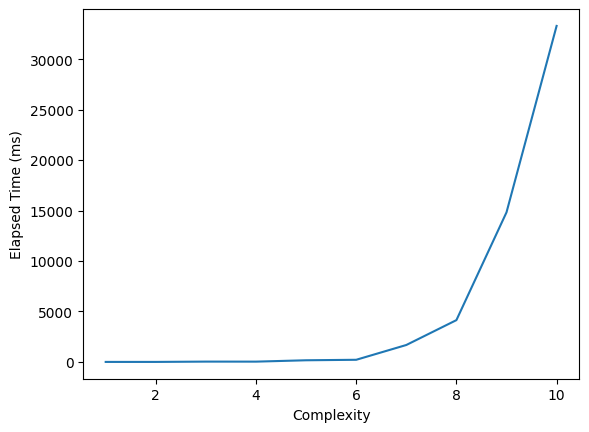

In [39]:
plt.plot('complexity', 'elapsed', data=bfs_data)
plt.ylabel('Elapsed Time (ms)')
plt.xlabel('Complexity')
plt.show()

#### A* Search

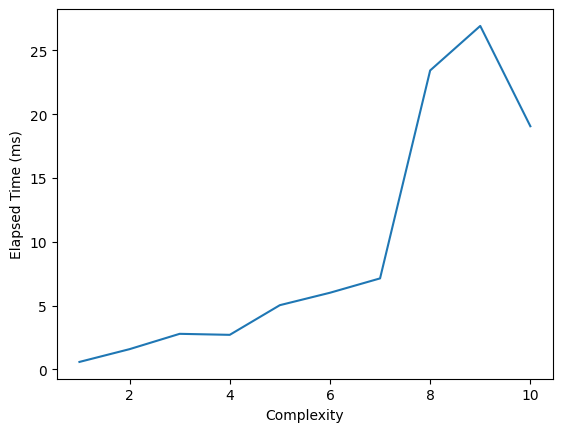

In [40]:
plt.plot('complexity', 'elapsed', data=a_star_data)
plt.ylabel('Elapsed Time (ms)')
plt.xlabel('Complexity')
plt.show()